# Fat Levels Classification of Canadian Cheeses

**This project was created as part of the 'Machine Learning' course at UBC.**

The aim of this project is to classify Canadian cheeses into different fat level categories using their specific characteristics.

**The central question is**: "Can we accurately categorize cheeses by their fat levels based on factors like moisture content, manufacturing methods, and other relevant attributes?

This question is significant because fat content plays a key role in defining the type and quality of cheese, influencing both consumer preferences and industry standards. Properly classifying fat levels helps manufacturers label their products accurately and enables consumers to make better-informed decisions.

In the context of **Supervised machine learning**, this problem is best suited for **Classification**, as we are aiming to categorize cheeses into discrete fat level groups rather than predicting a continuous value. The objective is to build a classification model that can use the given features to correctly categorize the fat levels and evaluate its performance using appropriate classification metrics.

In [1]:
# Import libraries needed for this project

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import lognorm, loguniform, randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Load the dataset:
cheese_df = pd.read_csv("/kaggle/input/canadian-cheese-directory/cheese_data.csv")
cheese_df.head(5)

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [3]:
# Drop features we are not going to use:
cheese_df = cheese_df.drop(columns=['CheeseId', 'FlavourEn', 'CharacteristicsEn', 'CheeseName', 'RindTypeEn'])

# Split the data into training and testing sets:
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=123)
train_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
482,QC,Artisan,48.0,0,Semi-soft Cheese,Cow,Pasteurized,lower fat
896,QC,Artisan,45.0,0,Veined Cheeses,Cow,Pasteurized,higher fat
421,QC,Industrial,50.0,0,Soft Cheese,Cow,Pasteurized,lower fat
929,BC,Artisan,40.0,0,Semi-soft Cheese,Cow,Pasteurized,higher fat
737,QC,Artisan,65.0,0,Fresh Cheese,Cow,Pasteurized,lower fat


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 833 entries, 482 to 1041
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       821 non-null    float64
 3   Organic               833 non-null    int64  
 4   CategoryTypeEn        813 non-null    object 
 5   MilkTypeEn            832 non-null    object 
 6   MilkTreatmentTypeEn   781 non-null    object 
 7   FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 58.6+ KB


In [5]:
train_df.describe(include='all')

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
count,833,833,821.000000,833.000000,813,832,781,833
unique,10,3,NaN,NaN,6,8,3,2
top,QC,Industrial,NaN,NaN,Firm Cheese,Cow,Pasteurized,lower fat
freq,635,370,NaN,NaN,271,596,648,548
mean,NaN,NaN,47.052741,0.091236,NaN,NaN,NaN,NaN
std,NaN,NaN,9.660351,0.288118,NaN,NaN,NaN,NaN
min,NaN,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,40.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,46.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,52.000000,0.000000,NaN,NaN,NaN,NaN


In [6]:
# Create a bar chart to visualize the count of cheeses by category:

category_chart = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('count()', title='Count'),
    y=alt.Y('CategoryTypeEn', title='Cheese Category', sort='-x'),
    color='CategoryTypeEn'
).properties(
    title='Count of Cheeses by Category'
)

category_chart

alt.Chart(...)

In [7]:
# Create a bar chart to visualize the count of cheeses by milk type:

milk_type_chart = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('count()', title='Count'),
    y=alt.Y('MilkTypeEn', title='Milk Type', sort='-x'),
    color='MilkTypeEn'
).properties(
    title='Count of Cheeses by Milk Type'
)

milk_type_chart

alt.Chart(...)

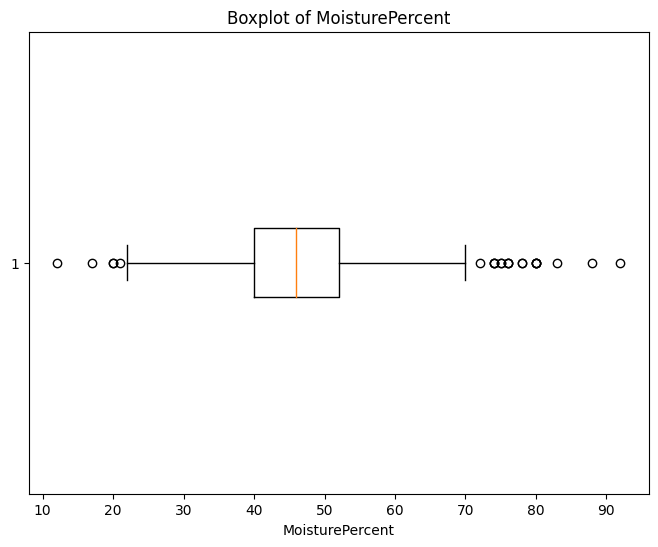

In [8]:
# Boxplot for MoisturePercent to check the outliers:

plt.figure(figsize=(8, 6))
plt.boxplot(train_df['MoisturePercent'].dropna(), vert=False)
plt.title('Boxplot of MoisturePercent')
plt.xlabel('MoisturePercent')
plt.show()

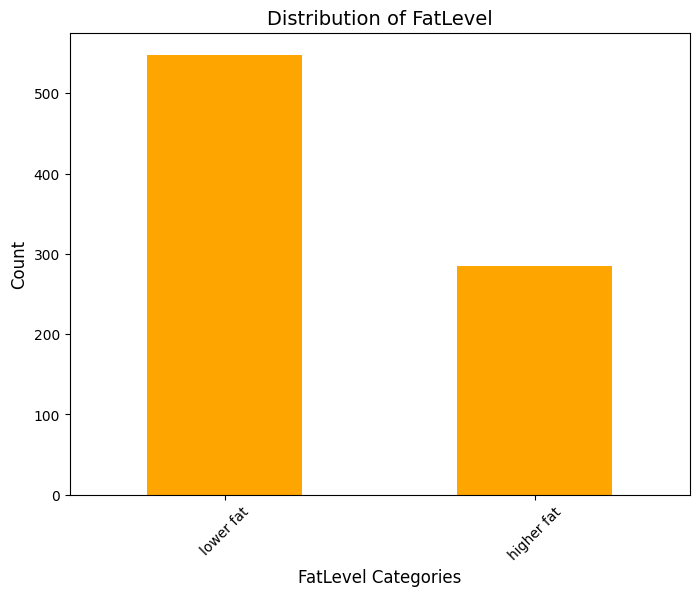

In [9]:
# Plotting the distribution of the target variable FatLevel:

plt.figure(figsize=(8, 6))
train_df['FatLevel'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of FatLevel', fontsize=14)
plt.xlabel('FatLevel Categories', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

**Data Exploration:**

1. Most features are categorical and will need to be transformed using One-Hot Encoding before applying machine learning models.

2. The MoisturePercent column has 12 missing values, CategoryTypeEn has 20 missing values and the MilkTreatmentTypeEn column has 52 missing values.
Imputation techniques will be necessary to handle missing data before building the model.

3. Several features exhibit unbalance:
- ManufacturerProvCode is highly skewed toward Quebec (QC).
- Organic is heavily skewed toward non-organic cheeses.
- MilkTypeEn is skewed toward cow’s milk.

3. The target variable FatLevel is imbalanced with 548 entries for "lower fat" and 285 entries for "higher fat." This imbalance might affect model performance and will need to be addressed using class weighting in the models.

4. In MoisturePercent plot we have outliers on both the low and high ends of the feature. I'll consider the outliers as valid data points that represent rare but possible values, and I will keep them since they provide important information about the data.

**Evaluation metrics we will use:**
1. **Recall** - focuses on the model’s ability to correctly identify all "Higher Fat" cheeses. In this case, misclassifying a "Higher Fat" cheese as "Lower Fat" could lead to more serious consequences, such as misleading consumers with dietary concerns.

2. **F1-Score** - provides a balanced metric that is particularly useful for imbalanced datasets. Since the dataset has more "lower fat" cheeses than "higher fat," this will help measure the model’s ability to handle both classes effectively.

3. **ROC-AUC** - will determine how well the model can distinguish between the "lower fat" and "higher fat" categories. Given the imbalance in the dataset, this metric will be useful in evaluating the model’s overall classification performance.

In this case, **Precision and Accuracy** are not as helpful because we are more concerned with correctly identifying all "higher fat" cheeses, which requires focusing on recall to minimize false negatives. Additionally, due to class imbalance (more "lower fat" cheeses), accuracy could be misleading, as a model might predict mostly "lower fat" and still achieve high accuracy without effectively identifying "higher fat" cheeses.

**From the dataset, we have identified three main types of features that require different preprocessing methods:**

1. **Numeric Features:** Continuous variables that require scaling and potentially handling missing values.

2. **Categorical Features:** Non-numeric data that represents categories and requires encoding into a numerical format (using one-hot encoding).

3. **Binary Features:** Features that contain only two possible values (0 or 1). We will encode binary features similarly to categorical features, with one value dropped to avoid multicollinearity.

In [10]:
# Define the numeric, categorical, and binary features for the model:

numeric_features = ['MoisturePercent']
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn']
binary_features = ['Organic']

In [11]:
# Create a preprocessor that applies appropriate transformations to all features:

preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()), numeric_features),
    (make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")), categorical_features),
    (OneHotEncoder(handle_unknown="error", drop="if_binary"), binary_features)
)

In [12]:
# Separate feature vectors from the target:

X_train = train_df.drop(columns=['FatLevel'])
y_train = train_df['FatLevel']

X_test = test_df.drop(columns=['FatLevel'])
y_test = test_df['FatLevel']

We need to encode the target variable; otherwise, the metrics will fail because they can't determine which label should be treated as the "positive" class.

In [13]:
# Encode the target labels:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Choice of Classification Algorithms:

Several classification algorithms were chosen based on their distinct properties. 

1. **Dummy Classifier** was initially used to set a baseline performance for comparison. 
2. **Logistic Regression** was included as a linear model due to its simplicity and effectiveness for binary classification.
3. **Random Forest** was selected for its ability to handle high-dimensional data and provide feature importance analysis.
4. **Support Vector Machines (SVM)** were evaluated for their capacity to handle non-linear relationships.
5. **Gradient Boosting** was tested due to its ability to iteratively improve model performance by combining weak learners.

In [14]:
# Train the baseline model:

dummy_clf = DummyClassifier(strategy='stratified', random_state=123)
scoring = ['accuracy', 'f1', 'recall', 'precision']
dummy_scores = cross_validate(dummy_clf, X_train, y_train_encoded, scoring=scoring, cv=5, return_train_score=True)

dummy_scores = pd.DataFrame(dummy_scores)
dummy_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.001409,0.007280,0.580838,0.566066,0.684685,0.671217,0.690909,0.673516,0.678571,0.668934
1,0.001046,0.008588,0.604790,0.566066,0.702703,0.671217,0.709091,0.673516,0.696429,0.668934
2,0.001001,0.007409,0.473054,0.569069,0.603604,0.673493,0.609091,0.675799,0.598214,0.671202
3,0.001828,0.009102,0.493976,0.562219,0.618182,0.668934,0.623853,0.671982,0.612613,0.665914
4,0.000988,0.008983,0.566265,0.568216,0.672727,0.673469,0.678899,0.676538,0.666667,0.670429


In [15]:
dummy_mean = dummy_scores.mean()
dummy_mean

fit_time           0.001255
score_time         0.008272
test_accuracy      0.543785
train_accuracy     0.566327
test_f1            0.656380
train_f1           0.671666
test_recall        0.662369
train_recall       0.674270
test_precision     0.650499
train_precision    0.669083
dtype: float64

We don't evaluate the model's performance based on Accuracy and Precision, but I would like to keep these metrics to see the full picture

In [16]:
# Train the basic linear model:

log_reg = make_pipeline(
    preprocessor,
    LogisticRegression(class_weight="balanced", random_state=123)
)
log_reg_scores = cross_validate(log_reg, X_train, y_train_encoded, scoring=scoring, cv=5,return_train_score=True)
log_reg_scores = pd.DataFrame(log_reg_scores)
log_reg_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.059590,0.016239,0.766467,0.765766,0.813397,0.808824,0.772727,0.753425,0.858586,0.873016
1,0.039900,0.014651,0.814371,0.762763,0.853081,0.808252,0.818182,0.760274,0.891089,0.862694
2,0.044374,0.016696,0.700599,0.792793,0.754902,0.833735,0.700000,0.789954,0.819149,0.882653
3,0.043198,0.014518,0.771084,0.781109,0.815534,0.823671,0.770642,0.776765,0.865979,0.876607
4,0.044106,0.018863,0.759036,0.770615,0.803922,0.812729,0.752294,0.756264,0.863158,0.878307


In [17]:
log_reg_mean = log_reg_scores.mean()
log_reg_mean

fit_time           0.046234
score_time         0.016193
test_accuracy      0.762312
train_accuracy     0.774609
test_f1            0.808167
train_f1           0.817442
test_recall        0.762769
train_recall       0.767337
test_precision     0.859592
train_precision    0.874655
dtype: float64

In [18]:
# Train the tree model:

rf_pipe = make_pipeline(
    preprocessor,
    RandomForestClassifier(class_weight="balanced", random_state=123)
)
rf_scores = cross_validate(rf_pipe, X_train, y_train_encoded, scoring=scoring, cv=5,return_train_score=True)
rf_scores = pd.DataFrame(rf_scores)
rf_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.402170,0.025374,0.820359,0.953453,0.858491,0.964245,0.827273,0.954338,0.892157,0.974359
1,0.411633,0.031976,0.820359,0.951952,0.859813,0.962791,0.836364,0.945205,0.884615,0.981043
2,0.373568,0.026856,0.832335,0.948949,0.871560,0.960739,0.863636,0.949772,0.879630,0.971963
3,0.383328,0.025575,0.837349,0.943028,0.875576,0.955814,0.871560,0.936219,0.879630,0.976247
4,0.378027,0.027528,0.807229,0.947526,0.847619,0.959350,0.816514,0.940774,0.881188,0.978673


In [19]:
rf_mean = rf_scores.mean()
rf_mean

fit_time           0.389745
score_time         0.027462
test_accuracy      0.823526
train_accuracy     0.948982
test_f1            0.862612
train_f1           0.960588
test_recall        0.843069
train_recall       0.945262
test_precision     0.883444
train_precision    0.976457
dtype: float64

In [20]:
# Train the Support Vector Classifier:

svm_pipe = make_pipeline(
    preprocessor,
    SVC(class_weight='balanced', random_state=123)
)
svm_scores = cross_validate(svm_pipe, X_train, y_train_encoded, scoring=scoring, cv=5, return_train_score=True)
svm_scores = pd.DataFrame(svm_scores)
svm_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.037776,0.018258,0.826347,0.813814,0.857143,0.848039,0.790909,0.789954,0.935484,0.915344
1,0.038231,0.017983,0.790419,0.822823,0.830918,0.853960,0.781818,0.787671,0.886598,0.932432
2,0.038348,0.018626,0.754491,0.831832,0.800000,0.860697,0.745455,0.789954,0.863158,0.945355
3,0.036992,0.018178,0.831325,0.818591,0.861386,0.852259,0.798165,0.794989,0.935484,0.918421
4,0.038970,0.019869,0.789157,0.823088,0.824121,0.855392,0.752294,0.794989,0.911111,0.925729


In [21]:
svm_mean = svm_scores.mean()
svm_mean

fit_time           0.038063
score_time         0.018583
test_accuracy      0.798348
train_accuracy     0.822030
test_f1            0.834713
train_f1           0.854069
test_recall        0.773728
train_recall       0.791511
test_precision     0.906367
train_precision    0.927456
dtype: float64

Let's try the **GradientBoostingClassifier** because it is a powerful ensemble method that combines the strengths of multiple weak learners (usually decision trees) to improve predictive performance. This model is well-suited for handling complex patterns in the data, making it effective in scenarios with non-linear relationships between features and the target variable.

In [22]:
# Train a Gradient Boosting model:

gbc_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=123))

gbc_scores = cross_validate(gbc_pipe, X_train, y_train_encoded, scoring=scoring, cv=5,return_train_score=True)
gbc_scores = pd.DataFrame(gbc_scores)
gbc_scores

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.201324,0.015324,0.850299,0.878378,0.893617,0.913183,0.954545,0.972603,0.840000,0.860606
1,0.190823,0.015827,0.820359,0.896396,0.868421,0.923077,0.900000,0.945205,0.838983,0.901961
2,0.194921,0.016442,0.814371,0.884384,0.866953,0.916936,0.918182,0.970320,0.821138,0.869121
3,0.198367,0.014883,0.831325,0.866567,0.878261,0.904198,0.926606,0.956720,0.834711,0.857143
4,0.186428,0.015354,0.825301,0.877061,0.873362,0.912766,0.917431,0.977221,0.833333,0.856287


In [23]:
gbc_mean = gbc_scores.mean()
gbc_mean

fit_time           0.194373
score_time         0.015566
test_accuracy      0.828331
train_accuracy     0.880557
test_f1            0.876123
train_f1           0.914032
test_recall        0.923353
train_recall       0.964414
test_precision     0.833633
train_precision    0.869024
dtype: float64

In [24]:
# Create a DataFrame to compare the models:

comparison_df = pd.DataFrame({
    'Dummy Classifier': dummy_mean,
    'Logistic Regression': log_reg_mean,
    'Random Forest': rf_mean,
    'SVM': svm_mean,
    'Gradient Boosting': gbc_mean
})

comparison_df

,Dummy Classifier,Logistic Regression,Random Forest,SVM,Gradient Boosting
fit_time,0.001255,0.046234,0.389745,0.038063,0.194373
score_time,0.008272,0.016193,0.027462,0.018583,0.015566
test_accuracy,0.543785,0.762312,0.823526,0.798348,0.828331
train_accuracy,0.566327,0.774609,0.948982,0.822030,0.880557
test_f1,0.656380,0.808167,0.862612,0.834713,0.876123
train_f1,0.671666,0.817442,0.960588,0.854069,0.914032
test_recall,0.662369,0.762769,0.843069,0.773728,0.923353
train_recall,0.674270,0.767337,0.945262,0.791511,0.964414
test_precision,0.650499,0.859592,0.883444,0.906367,0.833633
train_precision,0.669083,0.874655,0.976457,0.927456,0.869024


Based on the **test_f1 and test_recall** metrics, the top two models are **Random Forest Classifier and Gradient Boosting Classifier**. We will now optimize their hyperparameters to further improve performance.

In [25]:
# Define the hyperparameter distribution for Random Forest Classifier:
param_dist = {
    "randomforestclassifier__n_estimators": randint(10, 100),
    "randomforestclassifier__max_depth": randint(2, 10),
}

# Perform RandomizedSearchCV to optimize hyperparameters:
random_search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring="f1",
    random_state=123,
)

# Fit the model on the training data:
random_search_rf.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handl...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feedcf0e4d0>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feedc56aec0>},
                   random_state=123, scoring='f1', verbose=1)

In [26]:
# Retrieve the optimal hyperparameters and the best F1 score:

optimal_parameters_rf = random_search_rf.best_params_
optimal_score_rf = random_search_rf.best_score_
optimal_parameters_rf, optimal_score_rf

({'randomforestclassifier__max_depth': 8,
  'randomforestclassifier__n_estimators': 85},
 0.8697342010295649)

In [27]:
# Calculate and round the training and testing scores for the Random Forest model:

training_score_rf = round(random_search_rf.score(X_train, y_train_encoded),4)
testing_score_rf = round(random_search_rf.score(X_test, y_test_encoded),4)

training_score_rf, testing_score_rf

(0.9201, 0.8806)

In [28]:
# Get predicted probabilities Random Forest model:

y_test_probs_rf = random_search_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = round(roc_auc_score(y_test_encoded, y_test_probs_rf),4)
roc_auc_rf

0.905

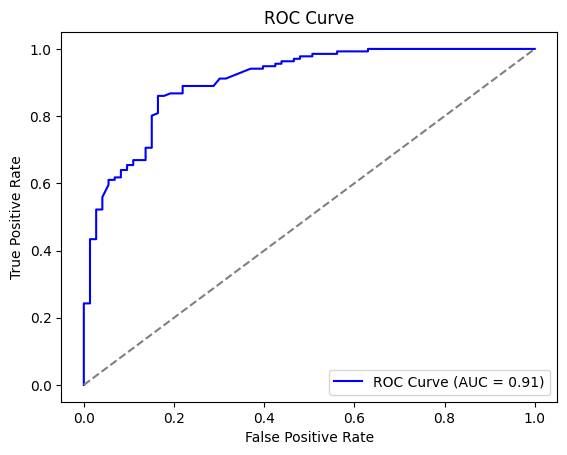

In [29]:
# Compute the ROC curve:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_test_probs_rf)

# Plot the ROC curve:
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Define the hyperparameter distribution for Gradient Boosting Classifier:
param_dist_gbc = {
    "gradientboostingclassifier__n_estimators": randint(20, 70),
    "gradientboostingclassifier__max_depth": randint(2, 10),
    "gradientboostingclassifier__min_samples_split": randint(2, 20),
    "gradientboostingclassifier__min_samples_leaf": randint(1, 20),
    "gradientboostingclassifier__subsample": uniform(0.5, 0.5),
    "gradientboostingclassifier__learning_rate": uniform(0.01, 0.3)
}

# Perform RandomizedSearchCV to optimize hyperparameters:
random_search_gbc = RandomizedSearchCV(
    gbc_pipe,
    param_distributions=param_dist_gbc,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring="f1",
    random_state=123,
)

# Fit the model on the training data:
random_search_gbc.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handl...
                                        'gradientboostingclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feedc568b50>,
                                        'gradientboostingclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feedcf47340>,
                                        'gradientboostingclassifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7feedc56b100>},
                   random_state=123, scoring='f1', verbose=1)

In [31]:
# Retrieve the optimal hyperparameters and the best F1 score:

optimal_parameters_gbc = random_search_gbc.best_params_
optimal_score_gbc = random_search_gbc.best_score_
optimal_parameters_gbc, optimal_score_gbc

({'gradientboostingclassifier__learning_rate': 0.16349641522460495,
  'gradientboostingclassifier__max_depth': 5,
  'gradientboostingclassifier__min_samples_leaf': 2,
  'gradientboostingclassifier__min_samples_split': 6,
  'gradientboostingclassifier__n_estimators': 50,
  'gradientboostingclassifier__subsample': 0.9274864079120382},
 0.8897441079259262)

In [32]:
# Calculate and round the training and testing scores for the Gradient Boosting Classifier:

training_score_gbc = round(random_search_gbc.score(X_train, y_train_encoded), 4)
testing_score_gbc = round(random_search_gbc.score(X_test, y_test_encoded), 4)

training_score_gbc, testing_score_gbc

(0.9434, 0.8864)

In [33]:
# Get predicted probabilities for Gradient Boosting:
y_test_probs_gbc = random_search_gbc.predict_proba(X_test)[:, 1]
roc_auc_gbc = round(roc_auc_score(y_test_encoded, y_test_probs_gbc),4)
roc_auc_gbc

0.9177

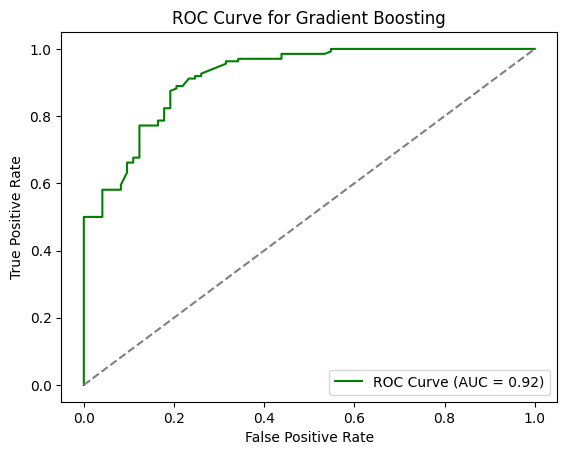

In [34]:
# Compute the ROC curve:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_test_probs_gbc)

# Plot the ROC curve:
plt.figure()
plt.plot(fpr, tpr, color='green', label='ROC Curve (AUC = %0.2f)' % roc_auc_gbc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

In [35]:
# Comparison of the scores from the two models:

model_scores = {
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Training Score': [training_score_rf, training_score_gbc],
    'Testing Score': [testing_score_rf, testing_score_gbc],
    'ROC AUC Score': [roc_auc_rf, roc_auc_gbc]
}

# Create the DataFrame from the scores:
results_df = pd.DataFrame(model_scores)
results_df

,Model,Training Score,Testing Score,ROC AUC Score
0,Random Forest,0.9201,0.8806,0.9050
1,Gradient Boosting,0.9434,0.8864,0.9177


## In comparing the two models, the training and testing scores indicate that the Random Forest model is slightly better.

**Here’s why:**

- Random Forest has a training score of 0.9201 and a testing score of 0.8806, indicating a well-generalized model with only a modest gap between training and testing scores.

- Gradient Boosting has a training score of 0.9434 and a testing score of 0.8864. Although it performs well, the slightly higher training score suggests some overfitting compared to the Random Forest model.

- Thus, Random Forest is performing slightly better and is more balanced between training and testing performance.

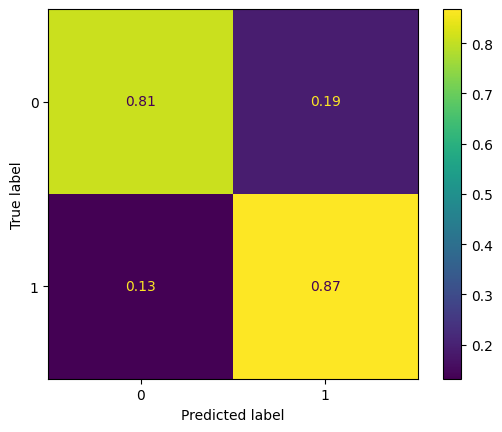

In [36]:
# Generate and plot the normalized confusion matrix to visualize the performance of the Random Forest model:

test_predictions = random_search_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test_encoded, test_predictions, normalize='true')
cm_plot = ConfusionMatrixDisplay(conf_matrix)
cm_plot.plot()

In [37]:
# Generate a classification report to evaluate the performance of the Random Forest model on the test set:

report = classification_report(y_test_encoded, test_predictions, output_dict=True)
report_df = pd.DataFrame(report)
report_df

,0,1,accuracy,macro avg,weighted avg
precision,0.766234,0.893939,0.84689,0.830087,0.849334
recall,0.808219,0.867647,0.84689,0.837933,0.846890
f1-score,0.786667,0.880597,0.84689,0.833632,0.847789
support,73.000000,136.000000,0.84689,209.000000,209.000000


# Concluding Remarks

- In this project, we aimed to predict the fat level in cheeses using various classification models.

- After preprocessing the data and testing multiple machine learning algorithms, we found that **Random Forest and Gradient Boosting** models performed best, especially in terms of **recall and f1-score**, which were our primary evaluation metrics. We selected these metrics because predicting "higher fat" cheeses incorrectly as "lower fat" could have serious health implications, so we prioritized minimizing false negatives.

# Interpretation of Results

- The final model, **Random Forest**, achieved a solid balance between training and testing scores with a test recall of 0.87 and an f1-score of 0.88.

- These results indicate that the model generalizes well and has a good ability to correctly identify "higher fat" cheeses without overfitting to the training data.

- The confusion matrix also reflects a relatively low number of false negatives, which was our primary concern given the context of the project.

# Limitations of the Model and Approach

While the Random Forest model performed well, there are several limitations:

**Data Size**: The dataset, although adequate, could benefit from more observations. A larger dataset could potentially improve the model's ability to generalize, especially for rare cheese types or lesser-known manufacturers.

**Imbalanced Data**: While we used class weighting to mitigate the impact of class imbalance between "lower fat" and "higher fat" cheeses, more advanced sampling techniques (e.g., SMOTE) could be explored to further enhance recall for "higher fat" cheeses.

**Overfitting Potential**: Although cross-validation was used, the difference between training and testing scores suggests that there might still be some overfitting. Further tuning could mitigate this issue.

# Potential Sources of Bias

Bias in our model could stem from:

**Manufacturer Bias**: Certain manufacturers and provinces appeared more frequently in the dataset, which could skew the model's predictions. If certain regions or manufacturers were underrepresented, the model might not generalize well to cheeses from those sources.

**Data Quality**: Missing values, particularly in the categorical features, were imputed with the most frequent values, which might introduce noise into the predictions. Alternative imputation strategies could be explored to improve the model's robustness.

# Ideas for Improvement

Several approaches could be tried to further enhance the model’s performance:

**Hyperparameter Optimization**: While we performed random search optimization, a more exhaustive grid search or Bayesian optimization might yield better hyperparameters.

**Ensemble Methods**: We could combine multiple models using ensemble techniques like stacking or voting to leverage the strengths of different models.

**Additional Feature Engineering**: We could explore more sophisticated feature engineering techniques, such as interaction terms or domain-specific knowledge, to better capture underlying patterns in the data.

By addressing these limitations and exploring further improvements, the model could achieve even greater accuracy and interpretability, ultimately enhancing its value for practical use in identifying cheese fat levels.

# List of References:

1. Gradient Boosting in Scikit-learn:
https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

2. ROC Curve and AUC:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

3. Matplotlib (Plotting Library):
https://matplotlib.org/stable/gallery/index.html

4. Imputing Missing Values in Scikit-learn:
https://scikit-learn.org/stable/modules/impute.html

5. RandomizedSearchCV Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html